In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn.functional as F
from torchvision.models import inception_v3, Inception_V3_Weights
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import nn

In [2]:
class CustomDataset(Dataset):
    def __init__(self, directory, cut):
        self.directory = directory
        self.cut_files = cut
        self.file_paths = self._load_file_paths()
        
    def _load_file_paths(self):
        files = [f for f in os.listdir(self.directory) if f.endswith('.npz')][:self.cut_files]
        files.sort(key=lambda x: int(os.path.splitext(x)[0]))
        return [os.path.join(self.directory, f) for f in files]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        data = np.load(file_path, allow_pickle=True)
        images = data['images'].reshape(-1, 50, 50)  # Shape: (660, 50, 50)

        images = (images / 127.5) - 1.0
        images = torch.from_numpy(images).float()
        images = images.unsqueeze(1)  # Shape: (660, 1, 50, 50)

        filename = os.path.splitext(os.path.basename(file_path))[0]
        return images, filename

def create_dataloader(directory, cut, batch_size=1, num_workers=0):
    dataset = CustomDataset(directory, cut)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # Input: (1, 50, 50)
            nn.Conv2d(1, 64, 5, stride=2, padding=2),  # 50 -> 25
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, 5, stride=2, padding=2),  # 25 -> 13
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 13 -> 7
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256*7*7, latent_dim)
        )
        # Decoder with precise dimension matching
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256*7*7),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (256, 7, 7)),
            
            # 7x7 -> 13x13
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=0),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            
            # 13x13 -> 25x25
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=0),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            
            # 25x25 -> 50x50
            nn.ConvTranspose2d(64, 1, 5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
        
        self._verify_dimensions()
    
    def _verify_dimensions(self):
        """Verify input-output dimension matching"""
        test_input = torch.randn(1, 1, 50, 50)
        with torch.no_grad():
            output = self.forward(test_input)
        assert output.shape == test_input.shape, \
            f"Shape mismatch: {output.shape} vs {test_input.shape}"

    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)

In [4]:
class ExponentialDecayScheduler:
    def __init__(self, optimizer, initial_lr, decay_rate, threshold=1e-4):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate
        self.epoch = 0
        self.threshold = threshold
        
        # Set initial learning rate
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = initial_lr
            
    def step(self):
        """Update learning rate after each epoch"""
        self.epoch += 1
        new_lr = self.initial_lr * (self.decay_rate ** self.epoch)
        if new_lr <= self.threshold:
            new_lr = self.threshold
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr
        

In [5]:
def train_autoencoder(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=50, device=torch.device('cpu')):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch, filename in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            # batch shape: (B, 660, 1, 50, 50)
            x = batch.view(-1, 1, 50, 50).to(device)  # Flatten to (B*660, 1, 50, 50)
            
            optimizer.zero_grad()
            recon = model(x)
            loss = criterion(recon, x)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch, filename in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                x = batch.view(-1, 1, 50, 50).to(device)
                recon = model(x)
                val_loss += criterion(recon, x).item()
        
        # Calculate epoch losses
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses

In [6]:
val_cut = 600
test_cut = 200
val_dir = './data/validation/'
test_dir = './data/test/'

train_loader = create_dataloader(val_dir, cut=val_cut, batch_size=8)
val_loader = create_dataloader(test_dir, cut = test_cut, batch_size=8)

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder(latent_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1)
criterion = nn.MSELoss()

scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1,
    patience=2,
    verbose=True
)


train_loss, val_loss = train_autoencoder(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    epochs=50,
    device=device
)

/home/davinci/miniconda3/envs/py10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50 [Val]: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


Epoch 1 | Train Loss: 7651.2712 | Val Loss: 11930.7119


Epoch 2/50 [Val]: 100%|██████████| 25/25 [00:18<00:00,  1.39it/s]


Epoch 2 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 3/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.51it/s]


Epoch 3 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 4/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]


Epoch 4 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 5/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


Epoch 5 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 6/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]


Epoch 6 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 7/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.52it/s]


Epoch 7 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 8/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.52it/s]


Epoch 8 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 9/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 9 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 10/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]


Epoch 10 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 11/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 11 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 12/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 12 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 13/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 13 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 14/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 14 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 15/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 15 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 16/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]


Epoch 16 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 17/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]


Epoch 17 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 18/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 18 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 19/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]


Epoch 19 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 20/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.39it/s]


Epoch 20 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 21/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]


Epoch 21 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 22/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 22 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 23/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 23 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 24/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 24 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 25/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 25 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 26/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 26 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 27/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 27 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 28/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 28 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 29/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 29 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 30/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 30 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 31/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 31 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 32/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]


Epoch 32 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 33/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 33 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 34/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 34 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 35/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 35 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 36/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 36 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 37/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 37 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 38/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 38 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 39/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 39 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 40/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 40 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 41/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.39it/s]


Epoch 41 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 42/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 42 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 43/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


Epoch 43 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 44/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


Epoch 44 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 45/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.39it/s]


Epoch 45 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 46/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]


Epoch 46 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 47/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.39it/s]


Epoch 47 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 48/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]


Epoch 48 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 49/50 [Val]: 100%|██████████| 25/25 [00:17<00:00,  1.39it/s]


Epoch 49 | Train Loss: 7651.0937 | Val Loss: 11930.7119


Epoch 50/50 [Val]: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]

Epoch 50 | Train Loss: 7651.0937 | Val Loss: 11930.7119


In [8]:
import random

def visualize_reconstruction(model, dataset, device, num_examples=3):
    """
    Visualizes original vs reconstructed images from the dataset
    Args:
        model: Trained AutoEncoder
        dataset: Your CustomDataset instance
        device: torch device
        num_examples: Number of examples to display
    """
    model.eval()
    fig, axs = plt.subplots(num_examples, 2, figsize=(8, 4*num_examples))
    
    with torch.no_grad():
        for i in range(num_examples):
            # Select random file and image
            file_idx = random.randint(0, len(dataset)-1)
            file_images = dataset[file_idx][0]  # Get all images from file (660, 1, 50, 50)
            
            # Select random image from the file
            img_idx = random.randint(0, 659)
            original = file_images[img_idx].unsqueeze(0).to(device)  # (1, 1, 50, 50)
            
            # Get reconstruction
            reconstructed = model(original)
            
            # Denormalize if using [-1, 1] normalization
            original = (original.squeeze().cpu() * 127.5 + 127.5).numpy().astype(np.uint8)
            reconstructed = (reconstructed.squeeze().cpu() * 127.5 + 127.5).numpy().astype(np.uint8)
            
            # Plot
            axs[i, 0].imshow(original, cmap='jet')
            axs[i, 0].set_title(f"Original\nFile: {dataset.file_paths[file_idx]}")
            axs[i, 0].axis('off')
            
            axs[i, 1].imshow(reconstructed, cmap='jet')
            axs[i, 1].set_title("Reconstructed")
            axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

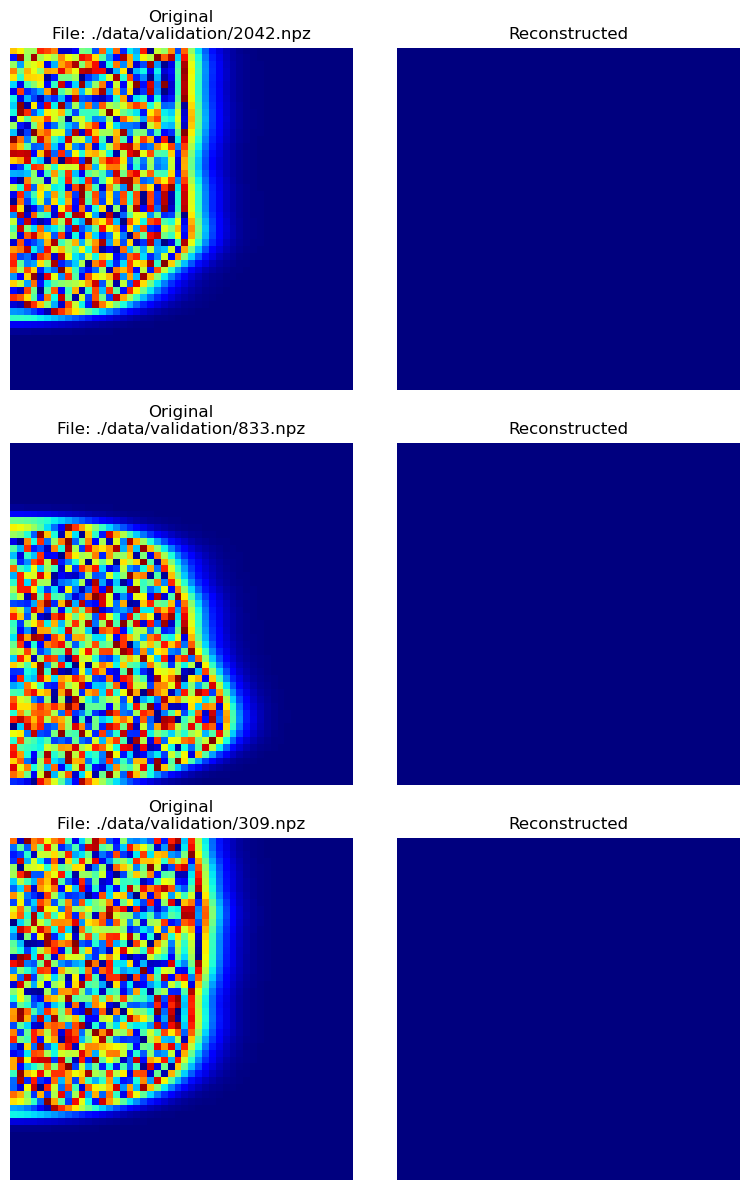

In [9]:
train_dataset = CustomDataset(val_dir, val_cut)
visualize_reconstruction(model, train_dataset, device)

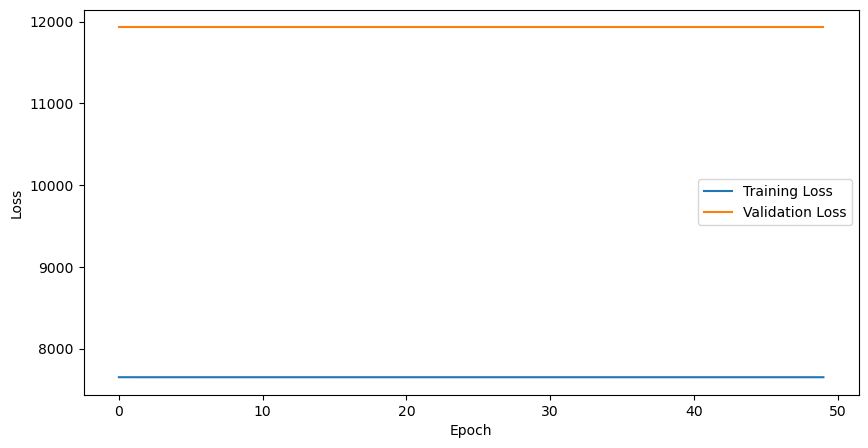

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#torch.save(model.state_dict(), 'best_autoencoder.pth')

In [ ]:
# def vectorize_file(file_path, model):
#     data = np.load(file_path, allow_pickle=True)
#     images = torch.from_numpy(data['images']).float().unsqueeze(1).to(device)  # (660, 1, 50, 50)
#     with torch.no_grad():
#         latents = model.encoder(images)  # (660, latent_dim)
#     return torch.mean(latents, dim=0).cpu().numpy()  # (latent_dim,)